### Введение
С развитием LLM-моделей спрашивать теоретическую часть или короткие алгоритмы и принципы стало бесполезно, поэтому задание будет одно, но комплексное и приближенное к реальности.

Вы можете использовать любые LLM-модели и Copilot для написания кода, так как в реальной работе сотрудники отдела также имеют доступ ко всем современным инструментам (Sonnet 3.5, GPT-4o, GitHub Copilot и т. п.).

В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---

### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

In [3]:
fees = fees.fillna(0.0)

### Часть 1 — упущенный процентный доход

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


In [4]:
import pandas as pd
from zeep import Client
from datetime import date
import datetime

# Указываем WSDL URL
wsdl_url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?WSDL"

# Создаем клиента для SOAP-запросов
client = Client(wsdl_url)

start_date = transactions['date'].min()
end_date = transactions['date'].max() + pd.Timedelta(days=1)
print((end_date - start_date).days)

print(start_date, end_date)

# Отправляем запрос на получение истории ключевой ставки
try:
    response = client.service.KeyRate(fromDate=start_date, ToDate=end_date)
except:
    print("error occured")


Forcing soap:address location to HTTPS
Forcing soap:address location to HTTPS


294
2024-01-12 00:00:00+00:00 2024-11-01 00:00:00+00:00


In [5]:
# Parsing
data = []
for item in response['_value_1']["_value_1"]:
    date = item['KR']['DT']
    rate = item['KR']['Rate']
    
    # Добавляем данные в список
    data.append([date, rate])

# Преобразуем список в pandas DataFrame
key_rates = pd.DataFrame(data, columns=['Date', 'KeyRate'])

# Преобразуем столбец Date в формат datetime (если это необходимо)
key_rates['Date'] = key_rates['Date'].apply(lambda x: x.astimezone(datetime.timezone.utc) if x.tzinfo else x)
key_rates['Date'] = pd.to_datetime(key_rates['Date'])

# Преобразуем столбец KeyRate в числовой формат
key_rates['KeyRate'] = key_rates['KeyRate'].astype(float)

In [6]:
transactions['date'] = transactions['date'].dt.tz_convert('UTC')

In [7]:

# Создаём полный список всех дат из transactions
all_dates = pd.date_range(start=transactions['date'].min(), end=transactions['date'].max(), freq='D')

key_rates.set_index('Date', inplace=True)

# Проводим forward fill для заполнения пропусков в ключевых ставках
key_rates = key_rates.reindex(all_dates, method='ffill')

# Восстанавливаем колонку Date для удобства
key_rates.reset_index(inplace=True)
key_rates.rename(columns={'index': 'Date'}, inplace=True)

# Теперь у нас есть заполненные key_rates с ставками, которые были повторены для недостающих дней


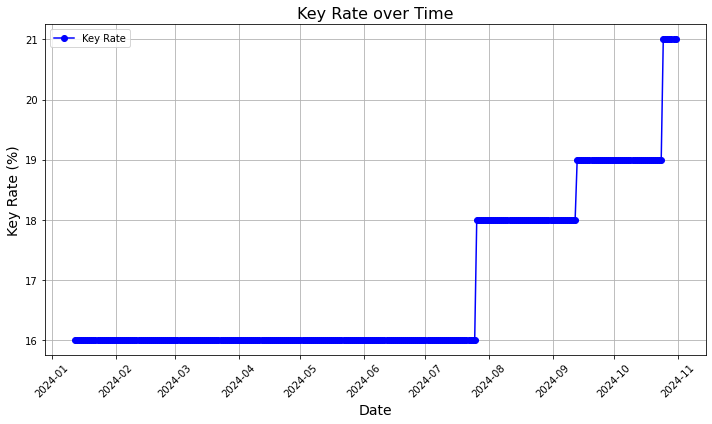

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(key_rates['Date'], key_rates['KeyRate'], marker='o', linestyle='-', color='b', label='Key Rate')

# Настроим график
plt.title('Key Rate over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Key Rate (%)', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Показать график
plt.tight_layout()
plt.show()

In [9]:

# Объединяем transactions и key_rates по дате
transactions = transactions.merge(key_rates, left_on='date', right_on='Date', how='left')


transactions['opportunity_cost'] = (
    transactions['bal_end_of_day'] * (transactions['KeyRate'] / 100) * (1 / 365)
)

transactions.drop(columns=['Date'], inplace=True)



### Часть 2 - расходы на инкассацию

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [10]:

# Сортируем данные по дате и ATM_ID
transactions = transactions.sort_values(['ATM_ID', 'date'])

# Получаем баланс на конец предыдущего дня
transactions['prev_bal_end_of_day'] = transactions.groupby('ATM_ID')['bal_end_of_day'].shift(1).fillna(0)

# Функция для расчета расходов на инкассацию
def calculate_fees(row, fees):
    atm_id = row['ATM_ID']
    
    # Получаем тарифы для текущего банкомата
    fee = fees[fees['ATM_ID'] == atm_id].iloc[0]
    
    # Расчет расходов на доставку
    cash_in = row['cash_in']
    prev_balance = row['prev_bal_end_of_day']
    
    if cash_in:
        cash_delivery_fee = fee['CashDeliveryFixedFee'] + max(cash_in * fee['CashDeliveryPercentageFee'], fee['CashDeliveryMinFee'])
        cash_collection_fee = fee['CashCollectionFixedFee'] + max(prev_balance * fee['CashCollectionPercentageFee'], fee['CashCollectionMinFee'])    
    else:
        cash_delivery_fee = 0
        cash_collection_fee = 0
    
    total_fees = cash_delivery_fee + cash_collection_fee
    
    return total_fees

transactions['incash_fees'] = transactions.apply(calculate_fees, axis=1, fees=fees)


In [11]:
transactions.drop(columns=["prev_bal_end_of_day"], inplace=True)

In [12]:
transactions.drop(columns=["KeyRate"], inplace=True)

In [13]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,opportunity_cost,incash_fees
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
8,2024-01-14 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
12,2024-01-15 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
16,2024-01-16 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...
1159,2024-10-27 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,433.031507,0.0
1163,2024-10-28 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,433.031507,0.0
1167,2024-10-29 00:00:00+00:00,ATM_4,748650.0,0.0,4000.0,430.730137,0.0
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0,430.154795,0.0


In [14]:
transactions_buf = transactions.copy()

### Часть 3 - анализ данных

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

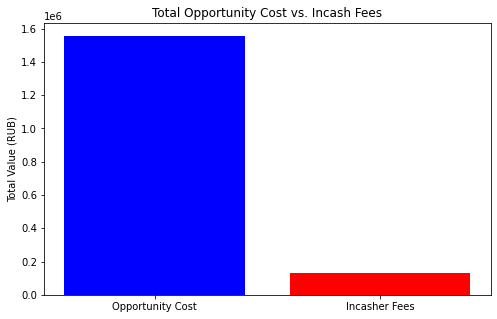

In [15]:
import matplotlib.pyplot as plt

# Суммарные значения по всем банкоматам
total_opportunity_cost = transactions['opportunity_cost'].sum()
total_incash_fees = transactions['incash_fees'].sum()

plt.figure(figsize=(8, 5))
plt.bar(['Opportunity Cost', 'Incasher Fees'], [total_opportunity_cost, total_incash_fees], color=['blue', 'red'])
plt.title('Total Opportunity Cost vs. Incash Fees')
plt.ylabel('Total Value (RUB)')
plt.show()


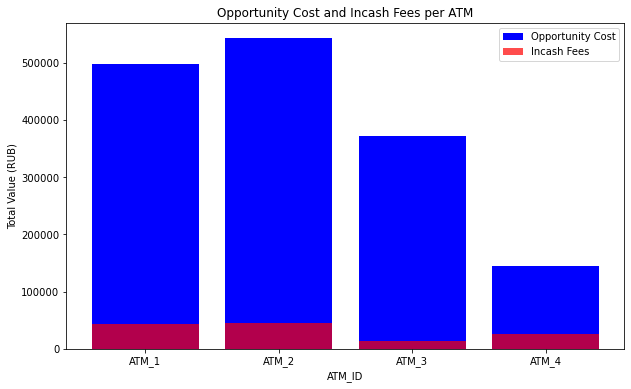

  ATM_ID  opportunity_cost  incash_fees      cash_in     cash_out
0  ATM_1     497849.709589    44474.000  144440000.0  114937500.0
1  ATM_2     542242.460274    45204.000  151740000.0  115170000.0
2  ATM_3     371188.591781    14625.000   23360000.0   17176300.0
3  ATM_4     145074.280822    26019.675    4890000.0    2551100.0


In [16]:
# Группировка по ATM_ID
atm_summary = transactions.groupby('ATM_ID').agg({
    'opportunity_cost': 'sum',
    'incash_fees': 'sum',
    'cash_in': 'sum',
    'cash_out': 'sum'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.bar(atm_summary['ATM_ID'], atm_summary['opportunity_cost'], label='Opportunity Cost', color='blue')
plt.bar(atm_summary['ATM_ID'], atm_summary['incash_fees'], label='Incash Fees', color='red', alpha=0.7)
plt.title('Opportunity Cost and Incash Fees per ATM')
plt.ylabel('Total Value (RUB)')
plt.xlabel('ATM_ID')
plt.legend()
plt.show()

print(atm_summary)


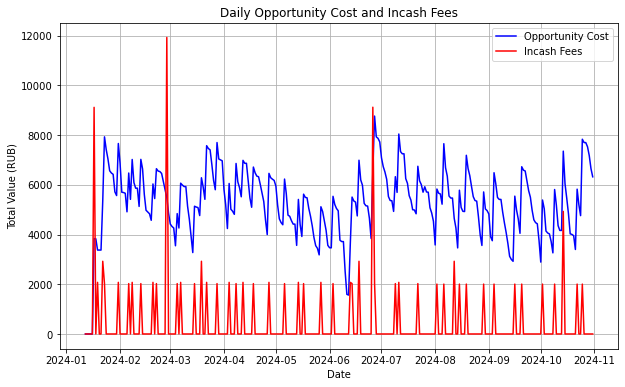

In [17]:
# Группировка по дате
daily_summary = transactions.groupby('date').agg({
    'opportunity_cost': 'sum',
    'incash_fees': 'sum'
}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(daily_summary['date'], daily_summary['opportunity_cost'], label='Opportunity Cost', color='blue')
plt.plot(daily_summary['date'], daily_summary['incash_fees'], label='Incash Fees', color='red')
plt.title('Daily Opportunity Cost and Incash Fees')
plt.xlabel('Date')
plt.ylabel('Total Value (RUB)')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Найдем топ-10 дней с наибольшими расходами на инкассацию
top_incash_days = transactions.sort_values(by='incash_fees', ascending=False).head(10)
print("Top 10 Days with Highest Incash Fees:")
print(top_incash_days[['date', 'ATM_ID', 'incash_fees', 'cash_in']])


Top 10 Days with Highest Incash Fees:
                          date ATM_ID  incash_fees    cash_in
191  2024-02-28 00:00:00+00:00  ATM_4    11930.650  1630000.0
667  2024-06-26 00:00:00+00:00  ATM_4     7047.025  1630000.0
23   2024-01-17 00:00:00+00:00  ATM_4     7042.000  1630000.0
270  2024-03-19 00:00:00+00:00  ATM_3     2925.000  5850000.0
42   2024-01-22 00:00:00+00:00  ATM_3     2925.000  5610000.0
1106 2024-10-14 00:00:00+00:00  ATM_3     2925.000  2940000.0
634  2024-06-18 00:00:00+00:00  ATM_3     2925.000  5980000.0
854  2024-08-12 00:00:00+00:00  ATM_3     2925.000  2980000.0
613  2024-06-13 00:00:00+00:00  ATM_2     2077.000  7120000.0
157  2024-02-20 00:00:00+00:00  ATM_2     2077.000  7120000.0


In [21]:
import pandas as pd
from scipy.stats import zscore

transactions['date'] = pd.to_datetime(transactions['date'])

transactions['day_of_week'] = transactions['date'].dt.dayofweek

transactions['month'] = transactions['date'].dt.month

# Добавляем флаг is_payday (5, 10, 15, 25) дни ЗП
paydays = [5, 10, 15, 25]
transactions['is_payday'] = transactions['date'].dt.day.isin(paydays).astype(int)

# Рассчитываем Z-оценку для cash_out (по каждому банкомату отдельно)
transactions['cash_out_zscore'] = transactions.groupby('ATM_ID')['cash_out'].transform(lambda x: zscore(x).round(2))


/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [23]:
transactions['7d_avg'] = transactions.groupby('ATM_ID')['cash_out'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
transactions['30d_avg'] = transactions.groupby('ATM_ID')['cash_out'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())



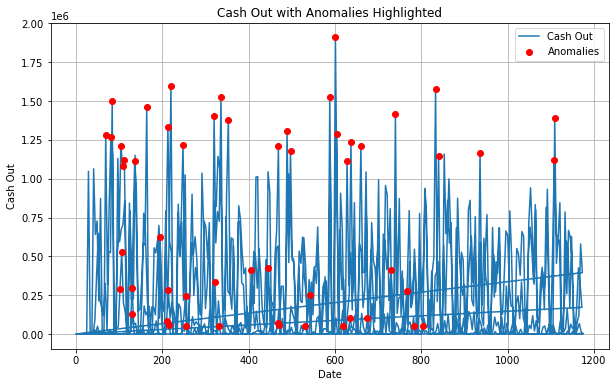

Anomalous days:
                          date ATM_ID  bal_end_of_day    cash_in   cash_out  \
84   2024-02-02 00:00:00+00:00  ATM_1       2094700.0        0.0  1499400.0   
104  2024-02-07 00:00:00+00:00  ATM_1       4762200.0        0.0  1211800.0   
108  2024-02-08 00:00:00+00:00  ATM_1       3678400.0        0.0  1083800.0   
112  2024-02-09 00:00:00+00:00  ATM_1       2559800.0        0.0  1118600.0   
136  2024-02-15 00:00:00+00:00  ATM_1       4692200.0        0.0  1112600.0   
164  2024-02-22 00:00:00+00:00  ATM_1       5156900.0  6620000.0  1463100.0   
220  2024-03-07 00:00:00+00:00  ATM_1       4238000.0        0.0  1594200.0   
248  2024-03-14 00:00:00+00:00  ATM_1        680300.0        0.0  1214800.0   
320  2024-04-01 00:00:00+00:00  ATM_1       4166700.0        0.0  1403600.0   
336  2024-04-05 00:00:00+00:00  ATM_1        542200.0        0.0  1523500.0   
588  2024-06-07 00:00:00+00:00  ATM_1       4101800.0        0.0  1526700.0   
604  2024-06-11 00:00:00+00:00  ATM_

In [24]:
from scipy.stats import zscore

# Фильтруем аномальные дни
period = "cash_out"
anomalies = transactions[transactions['cash_out_zscore'] > 2]

plt.figure(figsize=(10, 6))
plt.plot(transactions.index, transactions[period], label='Cash Out')
plt.scatter(anomalies.index, anomalies[period], color='red', label='Anomalies', zorder=5)
plt.title('Cash Out with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Cash Out')
plt.legend()
plt.grid()
plt.show()

print("Anomalous days:")
print(anomalies)


Количество аномалий по банкоматам:
ATM_ID
ATM_1    18
ATM_4    13
ATM_3    12
ATM_2    11
dtype: int64


<AxesSubplot:title={'center':'Number of Anomalies by ATM_ID'}, xlabel='ATM_ID'>

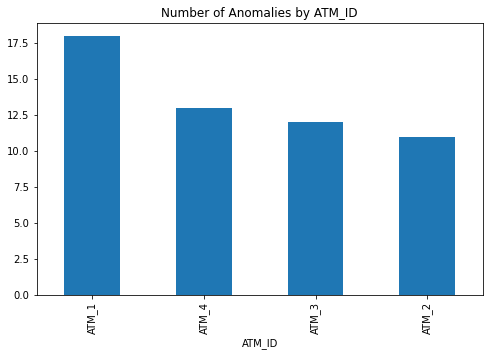

In [25]:
# Группируем аномалии по банкоматам
anomaly_counts = anomalies.groupby('ATM_ID').size().sort_values(ascending=False)

print("Количество аномалий по банкоматам:")
print(anomaly_counts)

# Визуализация топ банкоматов с аномалиями
anomaly_counts.plot(kind='bar', title='Number of Anomalies by ATM_ID', figsize=(8, 5))


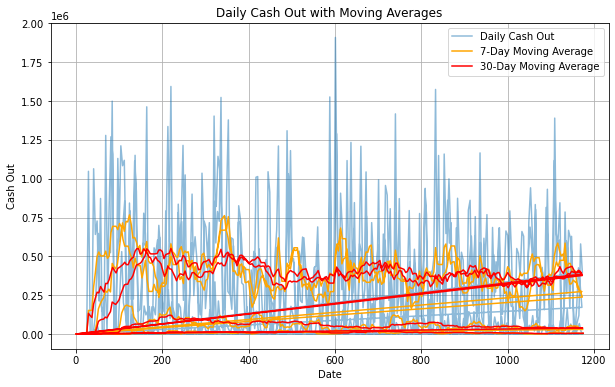

In [27]:

plt.figure(figsize=(10, 6))
plt.plot(transactions.index, transactions['cash_out'], label='Daily Cash Out', alpha=0.5)
plt.plot(transactions.index, transactions['7d_avg'], label='7-Day Moving Average', color='orange')
plt.plot(transactions.index, transactions['30d_avg'], label='30-Day Moving Average', color='red')
plt.title('Daily Cash Out with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Cash Out')
plt.legend()
plt.grid()
plt.show()


### Вывод - аномалий немного, выпадают в основном на pay_day, скользящие средние в целом ровные, сезонности нет. 
Оставим новые фичи в transactions. Используем randomForestRegressor для лучшего bias-variance

### Часть 4 - меняем бизнес с помощью ML

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


# Обычная model

In [29]:
# Создаем лаги cash_out
for lag in range(1, 8):  # Создаем 7 лагов (1-7 дней назад)
    transactions[f'cash_out_lag_{lag}'] = transactions.groupby('ATM_ID')['cash_out'].shift(lag)

# Удаляем строки с пропусками (из-за лагов)
transactions.dropna(subset=[f'cash_out_lag_{lag}' for lag in range(1, 8)], inplace=True)

# Проверяем результат
(transactions.head())


,date,ATM_ID,bal_end_of_day,cash_in,cash_out,opportunity_cost,incash_fees,day_of_week,month,is_payday,cash_out_zscore,7d_avg,30d_avg,cash_out_lag_1,cash_out_lag_2,cash_out_lag_3,cash_out_lag_4,cash_out_lag_5,cash_out_lag_6,cash_out_lag_7
28,2024-01-19 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,4,1,0,-1.14,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,2024-01-20 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,5,1,0,-1.14,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,2024-01-21 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,6,1,0,-1.14,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,2024-01-22 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,0,1,0,-1.14,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2024-01-23 00:00:00+00:00,ATM_1,6525100.0,6620000.0,94900.0,2860.317808,2027.0,1,1,0,-0.86,13557.142857,7908.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
transactions.drop(columns=["cash_out_zscore"], inplace=True)

In [31]:
# Признаки
features = [
    'day_of_week', 'month', 'is_payday',
    '7d_avg', '30d_avg'
] + [f'cash_out_lag_{lag}' for lag in range(1, 8)]  # Лаги

# Целевая переменная
target = 'cash_out'

# Разделяем данные на train/test
from sklearn.model_selection import train_test_split
X = transactions[features]
y = transactions[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Mean Absolute Error (MAE): 114528.3304347826


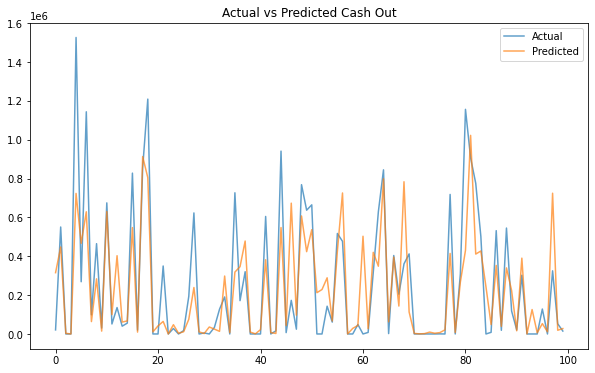

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Обучение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогноз на тестовой выборке
y_pred = model.predict(X_test)

# Оценка качества
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Визуализация факта и прогноза
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Cash Out')
plt.show()


In [33]:
# Начальные данные для прогноза (последние известные значения)
last_known = transactions[transactions['ATM_ID'] == 'ATM_1'].iloc[-1][features]

# Сохраним результаты прогноза
forecast = []

for day in range(7):
    # Прогнозируем следующий день
    next_cash_out = model.predict([last_known])[0]
    forecast.append(next_cash_out)
    
    # Обновляем признаки для следующего дня
    last_known = last_known.copy()
    last_known[f'cash_out_lag_1'] = next_cash_out  # Добавляем прогноз как lag_1
    for lag in range(2, 8):
        last_known[f'cash_out_lag_{lag}'] = last_known[f'cash_out_lag_{lag - 1}']  # Сдвигаем лаги

print(f'7-day Forecast: {forecast}')


7-day Forecast: [346463.0, 283262.0, 325851.0, 310467.0, 306611.0, 313134.0, 315378.0]


/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warni

In [34]:
days_until_delivery = 3
critical_balance = np.percentile(forecast[:days_until_delivery], 90)

print(f"Critical Balance (90th percentile of 3-day cash_out): {critical_balance}")

Critical Balance (90th percentile of 3-day cash_out): 342340.6


In [35]:
# Считаем сумму спроса на период до следующей инкассации (3 дня)
days_until_delivery = 3
critical_balance = np.percentile(forecast[:days_until_delivery], 90)
expected_demand = sum(forecast[:days_until_delivery])

# Добавляем резервный запас (20%)
reserve = 0.2 * expected_demand

# Рассчитываем оптимальное пополнение
optimal_cash_in = expected_demand + reserve

print(f"Expected Demand for {days_until_delivery} days: {expected_demand}")
print(f"Reserve (20% of demand): {reserve}")
print(f"Optimal Cash In: {optimal_cash_in}")


Expected Demand for 3 days: 955576.0
Reserve (20% of demand): 191115.2
Optimal Cash In: 1146691.2


In [36]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,opportunity_cost,incash_fees,day_of_week,month,is_payday,7d_avg,30d_avg,cash_out_lag_1,cash_out_lag_2,cash_out_lag_3,cash_out_lag_4,cash_out_lag_5,cash_out_lag_6,cash_out_lag_7
28,2024-01-19 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,4,1,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,2024-01-20 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,5,1,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,2024-01-21 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,6,1,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,2024-01-22 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,0,1,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2024-01-23 00:00:00+00:00,ATM_1,6525100.0,6620000.0,94900.0,2860.317808,2027.0,1,1,0,13557.142857,7908.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2024-10-27 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,433.031507,0.0,6,10,0,5400.000000,4466.666667,0.0,17800.0,0.0,0.0,20000.0,0.0,0.0
1163,2024-10-28 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,433.031507,0.0,0,10,0,5400.000000,4466.666667,0.0,0.0,17800.0,0.0,0.0,20000.0,0.0
1167,2024-10-29 00:00:00+00:00,ATM_4,748650.0,0.0,4000.0,430.730137,0.0,1,10,0,3114.285714,4600.000000,0.0,0.0,0.0,17800.0,0.0,0.0,20000.0
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0,430.154795,0.0,2,10,0,3257.142857,4633.333333,4000.0,0.0,0.0,0.0,17800.0,0.0,0.0


In [37]:
# Функция для расчета доставки наличных
def calculate_delivery_fee(cash_in, atm_id, fees_df):
    # Извлекаем строки с тарифами для банкомата
    fee = fees_df[fees_df['ATM_ID'] == atm_id].iloc[0]
    
    # Извлекаем параметры тарификации
    fixed_fee = fee['CashDeliveryFixedFee']
    percentage_fee = fee['CashDeliveryPercentageFee']
    min_fee = fee['CashDeliveryMinFee']
    
    # Рассчитываем доставку наличных
    return fixed_fee + max(cash_in * percentage_fee, min_fee)

# Функция для расчета замены кассеты
def calculate_cassette_fee(previous_balance, atm_id, fees_df):
    # Извлекаем строки с тарифами для банкомата
    fee = fees_df[fees_df['ATM_ID'] == atm_id].iloc[0]
    
    # Извлекаем параметры тарификации
    fixed_fee = fee['CashCollectionFixedFee']
    percentage_fee = fee['CashCollectionPercentageFee']
    min_fee = fee['CashCollectionMinFee']
    
    # Рассчитываем замену кассеты
    return fixed_fee + max(previous_balance * percentage_fee, min_fee)

# Начальный баланс и прогноз
atm_id = 'ATM_1'
current_balance = transactions[transactions['ATM_ID'] == atm_id]['bal_end_of_day'].iloc[-1]
previous_balance = current_balance
service_failures = 0

# Пример прогноза cash_out
#forecast = [20000, 25000, 18000, 22000, 26000, 24000, 21000]
forecast_with_costs = []

# Оптимизация на 7 дней
for day, predicted_out in enumerate(forecast):
    # Проверяем необходимость пополнения
    if current_balance - predicted_out < critical_balance:
        cash_in = optimal_cash_in  # Значение оптимального пополнения
        delivery_fee = calculate_delivery_fee(cash_in, atm_id, fees)
        cassette_fee = calculate_cassette_fee(previous_balance, atm_id, fees)
    else:
        cash_in = 0
        delivery_fee = 0
        cassette_fee = 0

    # Обновляем баланс и сохраняем предыдущий баланс
    previous_balance = current_balance
    current_balance = current_balance + cash_in - predicted_out

    # Проверяем Service Level
    if current_balance < 0:
        service_failures += 1

    # Сохраняем результаты
    forecast_with_costs.append({
        'day': day + 1,
        'cash_out': predicted_out,
        'cash_in': cash_in,
        'balance': current_balance,
        'delivery_fee': delivery_fee,
        'cassette_fee': cassette_fee,
        'total_fee': delivery_fee + cassette_fee
    })

# Вывод результатов
print("Forecast with Optimized Costs:")
for day_data in forecast_with_costs:
    print(day_data)

# Рассчитываем Service Level
service_level = 1 - service_failures / len(forecast)
print(f"Service Level: {service_level:.2%}")


Forecast with Optimized Costs:
{'day': 1, 'cash_out': 346463.0, 'cash_in': 0, 'balance': 2869037.0, 'delivery_fee': 0, 'cassette_fee': 0, 'total_fee': 0}
{'day': 2, 'cash_out': 283262.0, 'cash_in': 0, 'balance': 2585775.0, 'delivery_fee': 0, 'cassette_fee': 0, 'total_fee': 0}
{'day': 3, 'cash_out': 325851.0, 'cash_in': 0, 'balance': 2259924.0, 'delivery_fee': 0, 'cassette_fee': 0, 'total_fee': 0}
{'day': 4, 'cash_out': 310467.0, 'cash_in': 0, 'balance': 1949457.0, 'delivery_fee': 0, 'cassette_fee': 0, 'total_fee': 0}
{'day': 5, 'cash_out': 306611.0, 'cash_in': 0, 'balance': 1642846.0, 'delivery_fee': 0, 'cassette_fee': 0, 'total_fee': 0}
{'day': 6, 'cash_out': 313134.0, 'cash_in': 0, 'balance': 1329712.0, 'delivery_fee': 0, 'cassette_fee': 0, 'total_fee': 0}
{'day': 7, 'cash_out': 315378.0, 'cash_in': 0, 'balance': 1014334.0, 'delivery_fee': 0, 'cassette_fee': 0, 'total_fee': 0}
Service Level: 100.00%


In [38]:
import pandas as pd

# Конвертируем результаты forecast_with_costs в DataFrame
forecast_df = pd.DataFrame(forecast_with_costs)

# Проверяем полученный DataFrame
print(forecast_df)

# Дополнительно можно вывести статистику
print(forecast_df.describe())


   day  cash_out  cash_in    balance  delivery_fee  cassette_fee  total_fee
0    1  346463.0        0  2869037.0             0             0          0
1    2  283262.0        0  2585775.0             0             0          0
2    3  325851.0        0  2259924.0             0             0          0
3    4  310467.0        0  1949457.0             0             0          0
4    5  306611.0        0  1642846.0             0             0          0
5    6  313134.0        0  1329712.0             0             0          0
6    7  315378.0        0  1014334.0             0             0          0
            day       cash_out  cash_in       balance  delivery_fee  \
count  7.000000       7.000000      7.0  7.000000e+00           7.0   
mean   4.000000  314452.285714      0.0  1.950155e+06           0.0   
std    2.160247   19180.778258      0.0  6.707537e+05           0.0   
min    1.000000  283262.000000      0.0  1.014334e+06           0.0   
25%    2.500000  308539.000000      0

In [39]:
forecast_df

,day,cash_out,cash_in,balance,delivery_fee,cassette_fee,total_fee
0,1,346463.0,0,2869037.0,0,0,0
1,2,283262.0,0,2585775.0,0,0,0
2,3,325851.0,0,2259924.0,0,0,0
3,4,310467.0,0,1949457.0,0,0,0
4,5,306611.0,0,1642846.0,0,0,0
5,6,313134.0,0,1329712.0,0,0,0
6,7,315378.0,0,1014334.0,0,0,0


# Model is working RETROSPETIVE TEST

In [41]:
def calculate_delivery_fee(cash_in, atm_id, fees_df):
    # Извлекаем строки с тарифами для банкомата
    fee = fees_df[fees_df['ATM_ID'] == atm_id].iloc[0]
    
    # Извлекаем параметры тарификации
    fixed_fee = fee['CashDeliveryFixedFee']
    percentage_fee = fee['CashDeliveryPercentageFee']
    min_fee = fee['CashDeliveryMinFee']
    
    # Рассчитываем доставку наличных
    return fixed_fee + max(cash_in * percentage_fee, min_fee)

# Функция для расчета замены кассеты
def calculate_cassette_fee(previous_balance, atm_id, fees_df):
    # Извлекаем строки с тарифами для банкомата
    fee = fees_df[fees_df['ATM_ID'] == atm_id].iloc[0]
    
    # Извлекаем параметры тарификации
    fixed_fee = fee['CashCollectionFixedFee']
    percentage_fee = fee['CashCollectionPercentageFee']
    min_fee = fee['CashCollectionMinFee']
    
    # Рассчитываем замену кассеты
    return fixed_fee + max(previous_balance * percentage_fee, min_fee)

def calculate_opportunity_cost(cash_in, date, key_rate_df):
    # Получаем ключевую ставку для соответствующей даты
    key_rate = key_rate_df[key_rate_df['Date'] <= date].iloc[-1]['KeyRate']
    # Рассчитываем упущенную выгоду (opportunity cost)
    return cash_in * (key_rate / 100) / 365

In [42]:


# Дата начала прогноза
start_date = "2024-2-25"
atm_id = "ATM_4"

# Выбираем данные с начала прогноза
forecast_data = transactions[transactions['date'] <= start_date]

forecast_data = forecast_data[forecast_data["ATM_ID"] == atm_id]

last_known = forecast_data.iloc[-1][features]

# Сохраним результаты прогноза
forecast = []

for day in range(7):
    # Прогнозируем следующий день
    next_cash_out = model.predict([last_known])[0]
    forecast.append(next_cash_out)
    
    # Обновляем признаки для следующего дня
    last_known = last_known.copy()
    last_known[f'cash_out_lag_1'] = next_cash_out  # Добавляем прогноз как lag_1
    for lag in range(2, 8):
        last_known[f'cash_out_lag_{lag}'] = last_known[f'cash_out_lag_{lag - 1}']  # Сдвигаем лаги

print(f'7-day Forecast: {forecast}')

7-day Forecast: [7929.0, 12931.0, 10982.0, 11192.0, 11144.0, 11039.0, 11022.0]


/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warni

In [43]:
days_until_delivery = 3
critical_balance = np.percentile(forecast[:days_until_delivery], 90)
expected_demand = sum(forecast[:days_until_delivery])

# Добавляем резервный запас (20%)
reserve = 0.2 * expected_demand

# Рассчитываем оптимальное пополнение
optimal_cash_in = expected_demand + reserve

print(critical_balance)
print(expected_demand)

12541.2
31842.0


In [44]:
# Определяем критический баланс (например, 10% от текущего баланса)
days_until_delivery = 3
critical_balance = np.percentile(forecast[:days_until_delivery], 90)
expected_demand = sum(forecast[:days_until_delivery])

# Добавляем резервный запас (20%)
reserve = 0.2 * expected_demand

# Рассчитываем оптимальное пополнение
optimal_cash_in = expected_demand + reserve
critical_balance = 0.1 * forecast_data['bal_end_of_day'].iloc[-1]
print(critical_balance)
# Прогнозируем расходы на инкассацию для каждого дня
forecast_with_costs = []

current_balance = forecast_data['bal_end_of_day'].iloc[-1]
previous_balance = current_balance
service_failures = 0

for day, predicted_out in enumerate(forecast):
    # Проверяем, нужно ли пополнение
    if current_balance - predicted_out < critical_balance:
        cash_in = optimal_cash_in  # Определить оптимальную сумму пополнения, пока не оч, можно улучшить.
        delivery_fee = calculate_delivery_fee(cash_in, atm_id, fees)
        cassette_fee = calculate_cassette_fee(previous_balance, atm_id, fees)
    else:
        cash_in = 0
        delivery_fee = 0
        cassette_fee = 0

    # Обновляем баланс
    previous_balance = current_balance
    current_balance = current_balance + cash_in - predicted_out
    
    opportunity_cost = calculate_opportunity_cost(current_balance, start_date, key_rates)

    # Проверяем Service Level
    if current_balance < 0:
        service_failures += 1

    # Сохраняем результаты
    forecast_with_costs.append({
        'day': day + 1,
        'cash_out': predicted_out,
        'cash_in': cash_in,
        'balance': current_balance,
        'delivery_fee': delivery_fee,
        'cassette_fee': cassette_fee,
        'total_fee': delivery_fee + cassette_fee,
        'opportunity_cost': opportunity_cost
    })

# Переводим в DataFrame для удобства
forecast_df = pd.DataFrame(forecast_with_costs)


133990.0


In [45]:
forecast_df

,day,cash_out,cash_in,balance,delivery_fee,cassette_fee,total_fee,opportunity_cost
0,1,7929.0,0,1331971.0,0,0,0,583.877699
1,2,12931.0,0,1319040.0,0,0,0,578.209315
2,3,10982.0,0,1308058.0,0,0,0,573.395288
3,4,11192.0,0,1296866.0,0,0,0,568.489205
4,5,11144.0,0,1285722.0,0,0,0,563.604164
5,6,11039.0,0,1274683.0,0,0,0,558.765151
6,7,11022.0,0,1263661.0,0,0,0,553.933589


In [46]:
key_rates[key_rates["Date"] == start_date]

,Date,KeyRate
44,2024-02-25 00:00:00+00:00,16.0


In [47]:
total_incash_fees = forecast_df["total_fee"].sum()
total_opportunity_cost = forecast_df["opportunity_cost"].sum()
print(total_incash_fees+total_opportunity_cost)

3980.274410958904


In [48]:
feb1 = transactions[(transactions["date"]<='2024-03-03') & (transactions["ATM_ID"]==atm_id)
                   & ('2024-02-25'<=transactions["date"])]


In [49]:
feb1

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,opportunity_cost,incash_fees,day_of_week,month,is_payday,7d_avg,30d_avg,cash_out_lag_1,cash_out_lag_2,cash_out_lag_3,cash_out_lag_4,cash_out_lag_5,cash_out_lag_6,cash_out_lag_7
179,2024-02-25 00:00:00+00:00,ATM_4,1339900.0,0.0,0.0,587.353425,0.00,6,2,1,8735.714286,8820.000000,0.0,1000.0,20000.0,0.0,0.0,40150.0,0.0
183,2024-02-26 00:00:00+00:00,ATM_4,1339900.0,0.0,0.0,587.353425,0.00,0,2,0,3000.000000,8020.000000,0.0,0.0,1000.0,20000.0,0.0,0.0,40150.0
187,2024-02-27 00:00:00+00:00,ATM_4,1339700.0,0.0,200.0,587.265753,0.00,1,2,0,3028.571429,8026.666667,0.0,0.0,0.0,1000.0,20000.0,0.0,0.0
191,2024-02-28 00:00:00+00:00,ATM_4,1615000.0,1630000.0,15000.0,707.945205,11930.65,2,2,0,5171.428571,8526.666667,200.0,0.0,0.0,0.0,1000.0,20000.0,0.0
195,2024-02-29 00:00:00+00:00,ATM_4,1615000.0,0.0,0.0,707.945205,0.00,3,2,0,2314.285714,8526.666667,15000.0,200.0,0.0,0.0,0.0,1000.0,20000.0
199,2024-03-01 00:00:00+00:00,ATM_4,1615000.0,0.0,0.0,707.945205,0.00,4,3,0,2171.428571,8503.333333,0.0,15000.0,200.0,0.0,0.0,0.0,1000.0
203,2024-03-02 00:00:00+00:00,ATM_4,1615000.0,0.0,0.0,707.945205,0.00,5,3,0,2171.428571,8470.000000,0.0,0.0,15000.0,200.0,0.0,0.0,0.0
207,2024-03-03 00:00:00+00:00,ATM_4,1615000.0,0.0,0.0,707.945205,0.00,6,3,0,2171.428571,8470.000000,0.0,0.0,0.0,15000.0,200.0,0.0,0.0


In [50]:
total_incash_fees = feb1["incash_fees"].sum()
total_opportunity_cost = feb1["opportunity_cost"].sum()
print(total_incash_fees+total_opportunity_cost)

17232.348630136985


### Видим, что на прогнозых данных на 7 дней издержки меньше, чем на обычных данных. Оставляем этот подход и оборачиваем все в класс

# Генерализация

In [52]:
transactions = transactions_buf.copy()

In [102]:
class ATMOptimization:
    def __init__(self, transactions, fees, key_rate):
        self.transactions = transactions.copy()
        self.fees = fees.copy()
        self.key_rate = key_rate.copy()
        self.model = None
        
    def preprocess_data(self):
        
        # Предобрабатываем данные: добавляем флаги, средние по дням и т.д.
        self.transactions['date'] = pd.to_datetime(self.transactions['date'])
        self.transactions['day_of_week'] = self.transactions['date'].dt.dayofweek
        self.transactions['month'] = self.transactions['date'].dt.month
        paydays = [5, 10, 15, 25]
        self.transactions['is_payday'] = self.transactions['date'].dt.day.isin(paydays).astype(int)
        self.transactions['7d_avg'] = self.transactions.groupby('ATM_ID')['cash_out'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
        self.transactions['30d_avg'] = self.transactions.groupby('ATM_ID')['cash_out'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
    
        for lag in range(1, 8):  # Создаем 7 лагов (1-7 дней назад)
            self.transactions[f'cash_out_lag_{lag}'] = self.transactions.groupby('ATM_ID')['cash_out'].shift(lag)

#       Удаляем строки с пропусками (из-за лагов)
        self.transactions.dropna(subset=[f'cash_out_lag_{lag}' for lag in range(1, 8)], inplace=True)
    
    def train_model(self):
        
        features = ['day_of_week', 'month', 'is_payday','7d_avg', '30d_avg'] +\
                    [f'cash_out_lag_{lag}' for lag in range(1, 8)]  # Лаги

        # Целевая переменная
        target = 'cash_out'

        X = self.transactions[features]
        y = self.transactions[target]
        
        from sklearn.ensemble import RandomForestRegressor
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.model.fit(X, y)
    
    def forecast(self, start_date, atm_id, days_to_forecast=7):
        # Прогнозируем на day_to_forecast дней
        start_date = pd.to_datetime(start_date).tz_localize("UTC")
        forecast_data = self.transactions[(self.transactions['date'] <= start_date)
                                          & (self.transactions['ATM_ID'] == atm_id)]
        print(forecast_data)
        features = ['day_of_week', 'month', 'is_payday','7d_avg', '30d_avg'] +\
                    [f'cash_out_lag_{lag}' for lag in range(1, 8)]
        print(forecast_data)
        last_known = forecast_data.iloc[-1][features]
        
        forecast = []
        for day in range(days_to_forecast):
            next_cash_out = self.model.predict([last_known])[0]
            forecast.append(next_cash_out)
            last_known = last_known.copy()
            last_known[f'cash_out_lag_1'] = next_cash_out  # Добавляем прогноз как lag_1
            for lag in range(2, 8):
                last_known[f'cash_out_lag_{lag}'] = last_known[f'cash_out_lag_{lag - 1}']  # Сдвигаем лаги
                
        self.forecast_data = forecast_data.copy()
        return forecast
    
    def optimize_costs(self, forecast, atm_id, forecast_data, start_date):
        
        days_until_delivery = 3
        fcst_data = forecast_data.copy()
        critical_balance = np.percentile(forecast[:days_until_delivery], 90)
        expected_demand = sum(forecast[:days_until_delivery])
        # Добавляем резервный запас (20%)
        reserve = 0.2 * expected_demand
        # Рассчитываем оптимальное пополнение
        optimal_cash_in = expected_demand + reserve
        
        critical_balance = 0.1 * fcst_data['bal_end_of_day'].iloc[-1]

        
        # Оптимизация инкассации
        forecast_with_costs = []
        current_balance = fcst_data['bal_end_of_day'].iloc[-1]
        previous_balance = current_balance
        service_failures = 0
    

        for day, predicted_out in enumerate(forecast):
            # Проверяем, нужно ли пополнение
            
            if current_balance - predicted_out < critical_balance:
                cash_in = optimal_cash_in  # Определить оптимальную сумму пополнения, пока не оч, можно улучшить.
                delivery_fee = self.calculate_delivery_fee(cash_in, atm_id, fees)
                cassette_fee = self.calculate_cassette_fee(previous_balance, atm_id, fees)
            else:
                cash_in = 0
                delivery_fee = 0
                cassette_fee = 0

            # Обновляем баланс
            previous_balance = current_balance
            current_balance = current_balance + cash_in - predicted_out

            opportunity_cost = self.calculate_opportunity_cost(current_balance, start_date, self.key_rate)

            # Сохраняем результаты
            forecast_with_costs.append({
                'day': day + 1,
                'cash_out': predicted_out,
                'cash_in': cash_in,
                'balance': current_balance,
                'delivery_fee': delivery_fee,
                'cassette_fee': cassette_fee,
                'total_fee': delivery_fee + cassette_fee,
                'opportunity_cost': opportunity_cost
            })
            
        forecast_df = pd.DataFrame(forecast_with_costs)
        
        return forecast_df
    
    def calculate_delivery_fee(self, cash_in, atm_id, fees_df):
    # Извлекаем строки с тарифами для банкомата
        fee = fees_df[fees_df['ATM_ID'] == atm_id].iloc[0]

        # Извлекаем параметры тарификации
        fixed_fee = fee['CashDeliveryFixedFee']
        percentage_fee = fee['CashDeliveryPercentageFee']
        min_fee = fee['CashDeliveryMinFee']

        # Рассчитываем доставку наличных
        return fixed_fee + max(cash_in * percentage_fee, min_fee)

    # Функция для расчета замены кассеты
    def calculate_cassette_fee(self, previous_balance, atm_id, fees_df):
        # Извлекаем строки с тарифами для банкомата
        fee = fees_df[fees_df['ATM_ID'] == atm_id].iloc[0]

        # Извлекаем параметры тарификации
        fixed_fee = fee['CashCollectionFixedFee']
        percentage_fee = fee['CashCollectionPercentageFee']
        min_fee = fee['CashCollectionMinFee']

        # Рассчитываем замену кассеты
        return fixed_fee + max(previous_balance * percentage_fee, min_fee)

    def calculate_opportunity_cost(self, cash_in, date, key_rate_df):
        # Получаем ключевую ставку для соответствующей даты
        key_rate = key_rate_df[key_rate_df['Date'] <= date].iloc[-1]['KeyRate']
        # Рассчитываем упущенную выгоду (opportunity cost)
        return cash_in * (key_rate / 100) / 365

    def check_fees_and_cost(self, atm_id, start_date, forecast_df):
        
        start_date = pd.to_datetime(start_date).tz_localize("UTC")
        end_date = start_date + pd.Timedelta(days=7)
        
        to_check = self.transactions[(self.transactions["date"] < end_date) 
                                     & (self.transactions["ATM_ID"] == atm_id)
                                     & (start_date < self.transactions["date"])]
        incash_fees = to_check["incash_fees"].sum()
        oportunity_loss = to_check['opportunity_cost'].sum()
        
        incash_fees_fcst = forecast_df["total_fee"].sum()
        opportunity_loss_fcst = forecast_df["opportunity_cost"].sum()
        
        return to_check, incash_fees, opportunity_cost, incash_fees_fcst, opportunity_loss_fcst
        

In [103]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,opportunity_cost,incash_fees
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
8,2024-01-14 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
12,2024-01-15 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
16,2024-01-16 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...
1159,2024-10-27 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,433.031507,0.0
1163,2024-10-28 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,433.031507,0.0
1167,2024-10-29 00:00:00+00:00,ATM_4,748650.0,0.0,4000.0,430.730137,0.0
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0,430.154795,0.0


In [104]:
atm_check = ATMOptimization(transactions, fees, key_rates)

In [105]:
atm_check.preprocess_data()

In [106]:
atm_check.transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,opportunity_cost,incash_fees,day_of_week,month,is_payday,7d_avg,30d_avg,cash_out_lag_1,cash_out_lag_2,cash_out_lag_3,cash_out_lag_4,cash_out_lag_5,cash_out_lag_6,cash_out_lag_7
28,2024-01-19 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,4,1,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,2024-01-20 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,5,1,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,2024-01-21 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,6,1,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,2024-01-22 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000,0.0,0,1,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2024-01-23 00:00:00+00:00,ATM_1,6525100.0,6620000.0,94900.0,2860.317808,2027.0,1,1,0,13557.142857,7908.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2024-10-27 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,433.031507,0.0,6,10,0,5400.000000,4466.666667,0.0,17800.0,0.0,0.0,20000.0,0.0,0.0
1163,2024-10-28 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,433.031507,0.0,0,10,0,5400.000000,4466.666667,0.0,0.0,17800.0,0.0,0.0,20000.0,0.0
1167,2024-10-29 00:00:00+00:00,ATM_4,748650.0,0.0,4000.0,430.730137,0.0,1,10,0,3114.285714,4600.000000,0.0,0.0,0.0,17800.0,0.0,0.0,20000.0
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0,430.154795,0.0,2,10,0,3257.142857,4633.333333,4000.0,0.0,0.0,0.0,17800.0,0.0,0.0


In [107]:
atm_check.train_model()

In [108]:
#atm_check.forecast_data

In [109]:
start_date = "2024-02-25"
atm_id = "ATM_4"
prognoz = atm_check.forecast(start_date, atm_id)
print(prognoz)

                         date ATM_ID  bal_end_of_day  cash_in  cash_out  \
31  2024-01-19 00:00:00+00:00  ATM_4       1630000.0      0.0       0.0   
35  2024-01-20 00:00:00+00:00  ATM_4       1630000.0      0.0       0.0   
39  2024-01-21 00:00:00+00:00  ATM_4       1629500.0      0.0     500.0   
43  2024-01-22 00:00:00+00:00  ATM_4       1604500.0      0.0   25000.0   
47  2024-01-23 00:00:00+00:00  ATM_4       1604500.0      0.0       0.0   
51  2024-01-24 00:00:00+00:00  ATM_4       1604500.0      0.0       0.0   
55  2024-01-25 00:00:00+00:00  ATM_4       1604500.0      0.0       0.0   
59  2024-01-26 00:00:00+00:00  ATM_4       1604500.0      0.0       0.0   
63  2024-01-27 00:00:00+00:00  ATM_4       1580500.0      0.0   24000.0   
67  2024-01-28 00:00:00+00:00  ATM_4       1580500.0      0.0       0.0   
71  2024-01-29 00:00:00+00:00  ATM_4       1580500.0      0.0       0.0   
75  2024-01-30 00:00:00+00:00  ATM_4       1580500.0      0.0       0.0   
79  2024-01-31 00:00:00+0

/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/stronius/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warni

In [110]:
forecast_df = atm_check.optimize_costs(prognoz, atm_id, atm_check.forecast_data, start_date)

In [111]:
forecast_df

,day,cash_out,cash_in,balance,delivery_fee,cassette_fee,total_fee,opportunity_cost
0,1,1290.0,0,1338610.0,0,0,0,586.787945
1,2,12653.0,0,1325957.0,0,0,0,581.241425
2,3,7022.0,0,1318935.0,0,0,0,578.163288
3,4,11021.0,0,1307914.0,0,0,0,573.332164
4,5,7295.0,0,1300619.0,0,0,0,570.134356
5,6,11021.0,0,1289598.0,0,0,0,565.303233
6,7,7295.0,0,1282303.0,0,0,0,562.105425


In [112]:
to_check, incash_fees, opportunity_cost, fcst_inc, fcst_op = atm_check.check_fees_and_cost(atm_id, start_date, forecast_df)

In [113]:
print(f"Потери в деньгах на реальных данных на 7 дней вперед от начальной даты = {incash_fees + opportunity_cost}")
print(f"Потери в деньгах на предсказании на 7 дней вперед от начальной даты = {fcst_inc + fcst_op}")

Потери в деньгах на реальных данных на 7 дней вперед от начальной даты = 12484.583589041096
Потери в деньгах на предсказании на 7 дней вперед от начальной даты = 4017.067835616438


# Выгода!

## ToDo
1) конечно можно оформить все более красиво, прописать аннотацию типов, задекорировать все методы класса<br>
2) Конечно можно еще подумать над моделью и над optimal_cash_in (сейчас это просто запас + прогноз cahs_out на след день)<br>
3) Конечно можно еще все улучшать, но для первой итерации норм. (с учетом ограниченности времени и неоплачиваемости тестового задания)<br>
4) Конечно можно проверить модель на большем кол-ве данных, то есть не на 7 дней, а на месяц прогноз делать, может быть там
станет все хуже и мой подход не оправдается (см.п.3)<br>

В целом буду рад обратной связи, ожидать ее. Если будут вопросы - все поясню.
З.Ы. Немного странно на джуновскую позицию давать такое. Не мне решать, лучше бы классические собесы были. А с оправданием тестового это ловко придумали, я сразу и не понял.

### Заключение

Решение вы можете предоставить любым способом: репозиторий GitHub, Google Colab, конвертированный IPython Notebook в PDF и т. п.

По срокам вас не ограничивают, но учитывайте, что в это же время задачу могут решать и другие кандидаты. Таким образом, вы участвуете в конкурсе с ними.